## Modeling

---

In [277]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
pd.options.display.max_colwidth = 400
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
subreddit = pd.read_csv('../datasets/subreddit_combined.csv')

In [3]:
subreddit.head(2)

,link_flair_text,over_18,selftext,subreddit,title
0,Other,False,So in the venom 2 post credit venom says he recognizes peter Parker even though that venom has never met him because almost the moment venom arrived on earth he has been with Eddie or in a secret facility so could they have met in between movies?,Marvel,plot hole
1,Film/Television,False,"Alright, so I avoided this movie until today, what’s that like 12 years, because if the reviews and I gotta say, it was actually pretty good. Way better than the second Venom, let there be Carnage. \n\nForget other peoples opinions. Watch what you want.",Marvel,"Green lantern, not that bad."


In [4]:
X = subreddit[['selftext', 'title']]
y = subreddit['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55, stratify=y)

### Generating a Baseline Model

#### Since r/harrypotter is the majority class, it is the positive class (the one we're predicting). We want our models to have an accuracy score greater than 0.634.

In [5]:
y.value_counts(normalize=True)

harrypotter    0.636354
Marvel         0.363646
Name: subreddit, dtype: float64

### Making Logistic Regression Model with Count Vectorizer

In [11]:
ct1 = make_column_transformer((CountVectorizer(), 'selftext'), (CountVectorizer(), 'title'))

pipe1 = make_pipeline(ct1, LogisticRegression(max_iter=10_000))

pipe1.fit(X_train, y_train)
pipe1.score(X_train, y_train), pipe1.score(X_test, y_test)

(1.0, 0.9604166666666667)

##### Added stop words and "min_df" parameters to pipeline to test

In [233]:
ct2 = make_column_transformer(
    (CountVectorizer(stop_words='english', min_df=2), 'selftext'), 
    (CountVectorizer(stop_words='english', min_df=2), 'title'),
    remainder='passthrough'
)

pipe2 = make_pipeline(ct2, LogisticRegression(max_iter=10_000))

pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.9995833333333334, 0.9704166666666667)

In [273]:
len(pipe2.named_steps['logisticregression'].coef_[0])

16261

In [50]:
f1_score(y_test, pipe2.predict(X_test), pos_label='harrypotter')

0.9768804949527842

In [51]:
balanced_accuracy_score(y_test, pipe2.predict(X_test))

0.9659586773697725

In [235]:
model_coefs = pd.Series(pipe2.named_steps['logisticregression'].coef_[0], 
          index=pipe2.named_steps['columntransformer'].get_feature_names_out())

In [238]:
model_coefs.sort_values()

countvectorizer-2__marvel      -2.875286
countvectorizer-1__marvel      -2.875122
countvectorizer-1__comics      -2.167410
countvectorizer-1__comic       -2.150262
countvectorizer-2__mcu         -2.053449
                                  ...   
countvectorizer-2__voldemort    1.675842
countvectorizer-1__books        1.708333
countvectorizer-2__hogwarts     1.933589
countvectorizer-1__harry        2.175554
countvectorizer-2__harry        2.222952
Length: 16261, dtype: float64

In [266]:
coefs_df = pd.DataFrame(np.expm1(model_coefs).sort_values(ascending=False), columns=['coefs'])

#### Countvectorizer-1 is from the 'selftext', countvectorizer-2 is from the 'title'

In [275]:
coefs_df.round(2).head(30)

,coefs
countvectorizer-2__harry,8.23
countvectorizer-1__harry,7.81
countvectorizer-2__hogwarts,5.91
countvectorizer-1__books,4.52
countvectorizer-2__voldemort,4.34
countvectorizer-1__hogwarts,4.10
countvectorizer-2__dumbledore,4.03
countvectorizer-2__hp,3.47
countvectorizer-1__voldemort,3.37
countvectorizer-1__hp,3.33


##### The above coefficients show the relationship of the subreddit containing those words belonging to r/harrypotter. There are the highest values (aka the words most likely to be found in the r/harrypotter subreddit). For these values, the words are x-amount of times more likely to be found in r/harrypotter vs r/Marvel.

In [274]:
coefs_df.round(2).tail(30)

,coefs
countvectorizer-1__spider,-0.66
countvectorizer-1__eternals,-0.66
countvectorizer-1__thor,-0.66
countvectorizer-2__man,-0.66
countvectorizer-2__nwh,-0.67
countvectorizer-2__wolverine,-0.67
countvectorizer-2__multiverse,-0.68
countvectorizer-1__spiderman,-0.70
countvectorizer-1__wolverine,-0.70
countvectorizer-2__daredevil,-0.70


##### The above coefficients show the relationship of the subreddit containing those words belonging to r/Marvel. These values are represented in the negative as they are scored against r/harrypotter. The way to interpret these is as a positive percentage, e.g. the word "marvel" is 94% more likely to be found in r/Marvel vs r/harrypotter.

##### Added ngram_range parameters to pipeline to test

In [14]:
ct3 = make_column_transformer(
    (CountVectorizer(stop_words='english', min_df=2, ngram_range=(1,2)), 'selftext'), 
    (CountVectorizer(stop_words='english', min_df=2, ngram_range=(1,2)), 'title')
)

pipe3 = make_pipeline(ct3, LogisticRegression(max_iter=10_000))

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train), pipe3.score(X_test, y_test)

(0.9997222222222222, 0.9695833333333334)

##### Pipe2 with Logistic Regression has performed the best so far.

#### Grid Searching with Logistic Regression and Count Vectorizer

In [279]:
grid1 = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.001, 0.1, 1, 5, 50],
    'logisticregression__solver': ['lbfgs', 'liblinear'],
}

gs1 = GridSearchCV(pipe2, param_grid=grid1, n_jobs=-1)
gs1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('countvectorizer-1',
                                                                         CountVectorizer(min_df=2,
                                                                                         stop_words='english'),
                                                                         'selftext'),
                                                                        ('countvectorizer-2',
                                                                         CountVectorizer(min_df=2,
                                                                                         stop_words='english'),
                                                                         'title')])),
                                       ('logisticregression',
            

In [21]:
gs1.best_score_, gs1.best_estimator_

(0.9677777777777778,
 Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('countvectorizer-1',
                                                   CountVectorizer(min_df=2,
                                                                   stop_words='english'),
                                                   'selftext'),
                                                  ('countvectorizer-2',
                                                   CountVectorizer(min_df=2,
                                                                   stop_words='english'),
                                                   'title')])),
                 ('logisticregression',
                  LogisticRegression(C=1, max_iter=10000, solver='liblinear'))]))

In [26]:
gs1.best_params_

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [23]:
gs1.score(X_test, y_test)

0.9708333333333333

##### This score is better than the above logistic regression model by 0.0001, but it doesn't seem enough to automatically make me want to change the solver each time.

In [27]:
gs1.predict(X_test)

array(['harrypotter', 'harrypotter', 'harrypotter', ..., 'harrypotter',
       'harrypotter', 'Marvel'], dtype=object)

In [39]:
f1_score(y_test, gs1.predict(X_test), pos_label='harrypotter')

0.9771986970684039

In [41]:
balanced_accuracy_score(y_test, gs1.predict(X_test))

0.9665314150559122

#### Logistic Regressing Using Tfid Vectorizer
- With our best model from above.

In [53]:
ct4 = make_column_transformer(
    (TfidfVectorizer(stop_words='english', min_df=2), 'selftext'), 
    (TfidfVectorizer(stop_words='english', min_df=2), 'title')
)

pipe4 = make_pipeline(ct4, LogisticRegression(max_iter=10_000))

pipe4.fit(X_train, y_train)
pipe4.score(X_train, y_train), pipe4.score(X_test, y_test)

(0.9952777777777778, 0.9695833333333334)

##### The model above is still performing slightly better than this model with the Tfid Vectorizer.

### Fitting Random Trees & Extra Trees Models
- Using Count Vectorizer as that out performed the Tfid Vectorizer above.

In [56]:
ct5 = make_column_transformer(
    (CountVectorizer(stop_words='english', min_df=2), 'selftext'), 
    (CountVectorizer(stop_words='english', min_df=2), 'title')
)

pipe5 = make_pipeline(ct5, RandomForestClassifier())

pipe5.fit(X_train, y_train)
pipe5.score(X_train, y_train), pipe5.score(X_test, y_test)

(0.9998611111111111, 0.9604166666666667)

In [64]:
ct6 = make_column_transformer(
    (CountVectorizer(stop_words='english', min_df=2), 'selftext'), 
    (CountVectorizer(stop_words='english', min_df=2), 'title')
)

pipe6 = make_pipeline(ct6, ExtraTreesClassifier())

pipe6.fit(X_train, y_train)
pipe6.score(X_train, y_train), pipe6.score(X_test, y_test)

(0.9998611111111111, 0.9666666666666667)

##### Both of the above models were slightly lower in accuracy than the logistic regression ones.

#### Grid Searching Over Extra Trees

In [62]:
grid2 = {
    'extratreesclassifier__n_estimators': [100, 150, 200],
    'extratreesclassifier__max_depth': [None, 5, 7, 10, 12, 15],
    'extratreesclassifier__min_samples_split': [2, 3, 5],
}

gs2 = GridSearchCV(pipe6, param_grid=grid2, n_jobs=-1)
gs2.fit(X_train, y_train)
gs2.score(X_train, y_train), gs2.score(X_test, y_test)

(0.9998611111111111, 0.9670833333333333)

In [63]:
gs2.best_params_

{'extratreesclassifier__max_depth': None,
 'extratreesclassifier__min_samples_split': 3,
 'extratreesclassifier__n_estimators': 200}

##### This model is better, but still not as good as the Logistic Regression model above.

### Fitting KNN Model with Count Vectorizer

In [65]:
ct7 = make_column_transformer(
    (CountVectorizer(stop_words='english', min_df=2), 'selftext'), 
    (CountVectorizer(stop_words='english', min_df=2), 'title')
)

pipe7 = make_pipeline(ct7, KNeighborsClassifier())

pipe7.fit(X_train, y_train)
pipe7.score(X_train, y_train), pipe7.score(X_test, y_test)

(0.7906944444444445, 0.745)

##### This KNN model is not good, I won't be pursuing it any further.

### Trying Lemmatizer in our best LogReg model.

In [66]:
class LemmaTokenizer():
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(w) for w in word_tokenize(doc)]

In [278]:
ct8 = make_column_transformer(
    (CountVectorizer(stop_words='english', min_df=2, tokenizer=lemma_tokenizer), 'selftext'), 
    (CountVectorizer(stop_words='english', min_df=2, tokenizer=lemma_tokenizer), 'title')
)

pipe8 = make_pipeline(ct8, LogisticRegression(max_iter=10_000))

pipe8.fit(X_train, y_train)
pipe8.score(X_train, y_train), pipe8.score(X_test, y_test)

(0.9993055555555556, 0.9683333333333334)

##### Using the lemmatizer actually brought the score down slightly. 

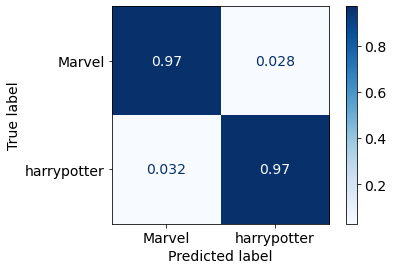

In [209]:
plt.rcParams.update({'font.size': 14}),
ConfusionMatrixDisplay.from_estimator(pipe2, X_test, y_test, normalize='pred', cmap='Blues'),
plt.savefig('../images/confusion_matrix');

The above is a confusion matrix for the predictions coming from the best model on the test set, the Logistic Regression one using Count Vectorizer. This is showing that the model is predicting the true Marvel label about 97% of the time, and the Harry Potter label also around 97% percent of the time. The false positive and negative frequence is very small, being 2.8% and 3.2% respectively.

---

## Conclusions and Recommendations

During the modeling process, I found the good 'ol Logistic Regression model to work the best. It performed remarkably well with these two subreddits, and my hypoethesis is that the two subreddits are so different that the model was easily able to pick up on that. There was a consistent pattern where in the r/harrypotter subreddit, the word 'harry' was both the most common word in the title and selftext and also had the most impactful coefficient. Similarly, in the r/Marvel subreddit the word 'marvel' was both the most common in title and selftext and also carried the most weight with the coefficient.

For this project, I didn't go into the missclassifications the model was making, but that is something that would be worth looking into moving forward. Another interesting thing to try would be to add the words 'harry' and 'marvel' to the stop words list to see if the model is still as effective at distinguishing between the two subreddits. There are also other words and bigrams that would be interesting to add to the stop words as well.

My recommendations for this model would be to continue to gather data for different time periods moving forward and testing the model. Since both of these fields change fairly regularly, any new data could potentially affect the accuracy of the model. Many of the words that were showing up in each subreddit frequently corresponded to current shows and/or movies that are airing or releasing during the time period of the posts. If we were to collect new data 6 months from now, I'm sure some of those most frequent words would be different to reflect the newer stuff that is popular. 